In [161]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
from operator import itemgetter

(-0.5, 1919.5, 1079.5, -0.5)

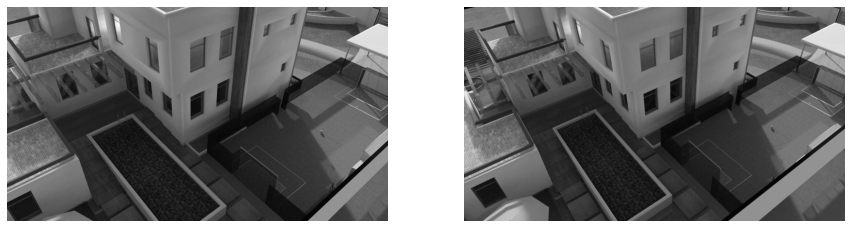

In [162]:
img1 = cv2.imread('./Frame1.png', 0)
img2 = cv2.imread('./Frame2.png', 0)

f, axs = plt.subplots(1,2,figsize=(15,15))
axs[0].imshow(img1, cmap='gray')
axs[0].axis('off')

axs[1].imshow(img2, cmap='gray')
axs[1].axis('off')

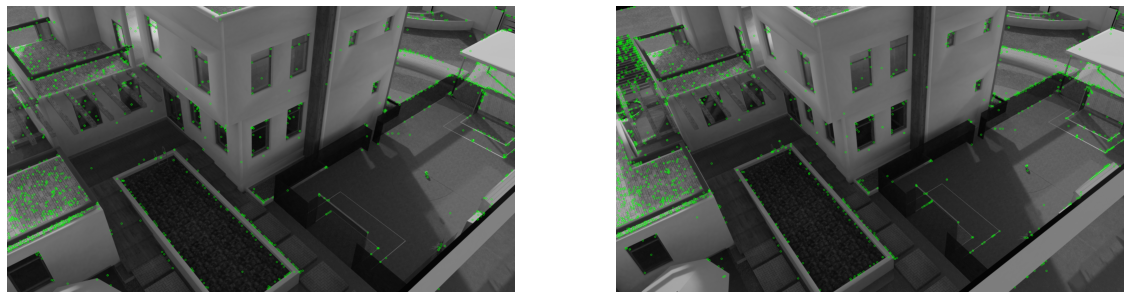

In [163]:
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# Detect the key points and corresponding feature descriptor
kp_1, des_1 = sift.detectAndCompute(img1, None)
kp_2, des_2 = sift.detectAndCompute(img2, None)

# Draw the key points
img1_keypoints = cv2.drawKeypoints(img1, kp_1, None, [0, 255, 0], flags=0)
img2_keypoints = cv2.drawKeypoints(img2, kp_2, None, [0, 255, 0], flags=0)

f, axs = plt.subplots(1,2,figsize=(20,20))
axs[0].imshow(img1_keypoints)
axs[0].axis('off')

axs[1].imshow(img2_keypoints)
axs[1].axis('off')

plt.savefig('detected_corners.png')

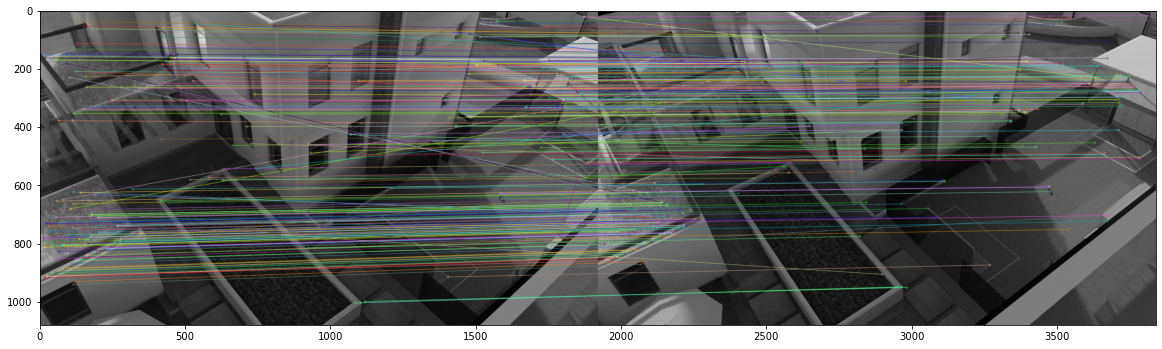

<Figure size 432x288 with 0 Axes>

In [164]:
bf = cv2.BFMatcher(cv2.NORM_L1,crossCheck=False)
matches = bf.knnMatch(des_1, des_2, k=2)

# Apply ratio test
good_matches = []
pts1 = []
pts2 = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good_matches.append([m])
        pts2.append(kp_2[m.trainIdx].pt)
        pts1.append(kp_1[m.queryIdx].pt)

# cv2.drawMatchesKnn expects list of lists as matches
img3 = cv2.drawMatchesKnn(img1, kp_1, img2, kp_2, good_matches, None, flags=2)
fig, axs=plt.subplots(1,1, figsize=(20,20)) 
axs.imshow(img3, cmap='gray')
plt.imshow(img3), plt.show()
plt.savefig('matched_corners.png')

In [165]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

# Compute the fundamental matrix based on the matched points 
# Using the 8-point algorithm
F_feature, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_8POINT)
print(F_feature)

[[ 1.45780872e-07  1.51489831e-05 -7.42647585e-03]
 [-1.49632760e-05  1.85247827e-06  3.83679160e-04]
 [ 6.77690395e-03 -3.23737839e-03  1.00000000e+00]]


In [166]:
# Compute the fundamental matrix using the intrinsic and extrinsic parameters
K = np.array([[1.600e+03, 0.000e+00, 9.595e+02], 
              [0.000e+00, 1.600e+03, 5.395e+02], 
              [0.000e+00, 0.000e+00, 1.000e+00]])
K_dash = np.array([[1.49333333e+03, 0.00000000e+00, 9.78700000e+02], 
                   [0.00000000e+00, 1.49333333e+03, 5.20300000e+02],
                   [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
T = np.array([-1.98989457, 0.00265269, 0.20979508])
R = np.array([[ 0.9971792 , -0.00348069, 0.07497863], 
              [ 0.00362138, 0.99999203, -0.00174044], 
              [-0.07497205, 0.00200697, 0.99718366]])

[a_x, a_y, a_z] = [i for i in (K_dash @ T)]
K_dash_T_square = np.array([[0, -a_z, a_y],
                            [a_z, 0, -a_x],
                            [-a_y, a_x, 0]])

K_inverse = np.linalg.inv(K)
F_param = K_dash_T_square @ K_dash @ R @ K_inverse
print(F_param)

# Alternatively
[b_x, b_y, b_z] = [i for i in T]
T_square = np.array([[0, -b_z, b_y],
                     [b_z, 0, -b_x],
                     [-b_y, b_x, 0]])
F_param2 = np.transpose(np.linalg.inv(K_dash)) @ T_square @ R @ K_inverse
print(F_param2)

# Alternatively
[c_x, c_y, c_z] = [i for i in (np.transpose(R) @ T)]
RtT_square = np.array([[0, -c_z, c_y],
                       [c_z, 0, -c_x],
                       [-c_y, c_x, 0]])
F_param3 = np.transpose(np.linalg.inv(K_dash)) @ R @ RtT_square @ K_inverse
print(F_param3)

[[-8.94716958e-04 -1.95802211e-01  1.10989237e+02]
 [ 5.60156937e-02  3.04586526e-03  2.93130697e+03]
 [-4.19999288e+01 -2.58338899e+03 -1.17061260e+05]]
[[-4.01210372e-10 -8.78019327e-08  4.97699667e-05]
 [ 2.51186447e-08  1.36583164e-09  1.31446124e-03]
 [-1.88336735e-05 -1.15844731e-03 -5.24927926e-02]]
[[-4.01209152e-10 -8.78019393e-08  4.97699574e-05]
 [ 2.51187080e-08  1.36590325e-09  1.31446141e-03]
 [-1.88336916e-05 -1.15844744e-03 -5.24930105e-02]]


In [153]:
def Average(lst):
    return sum(lst) / len(lst)

In [154]:
print(pts2.shape[0])

feature_set = []
param2_set = []
for i in range(pts1.shape[0]):
    feature_set.append(np.transpose(np.append(pts2[i],1)) @ F_feature @ np.append(pts1[i],1))
    param2_set.append(np.transpose(np.append(pts2[i],1)) @ F_param2 @ np.append(pts1[i],1))
print(Average(feature_set))
print(Average(param2_set))

327
-0.013266731497485263
0.004365877211281218


In [167]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

(-0.5, 1919.5, 1079.5, -0.5)

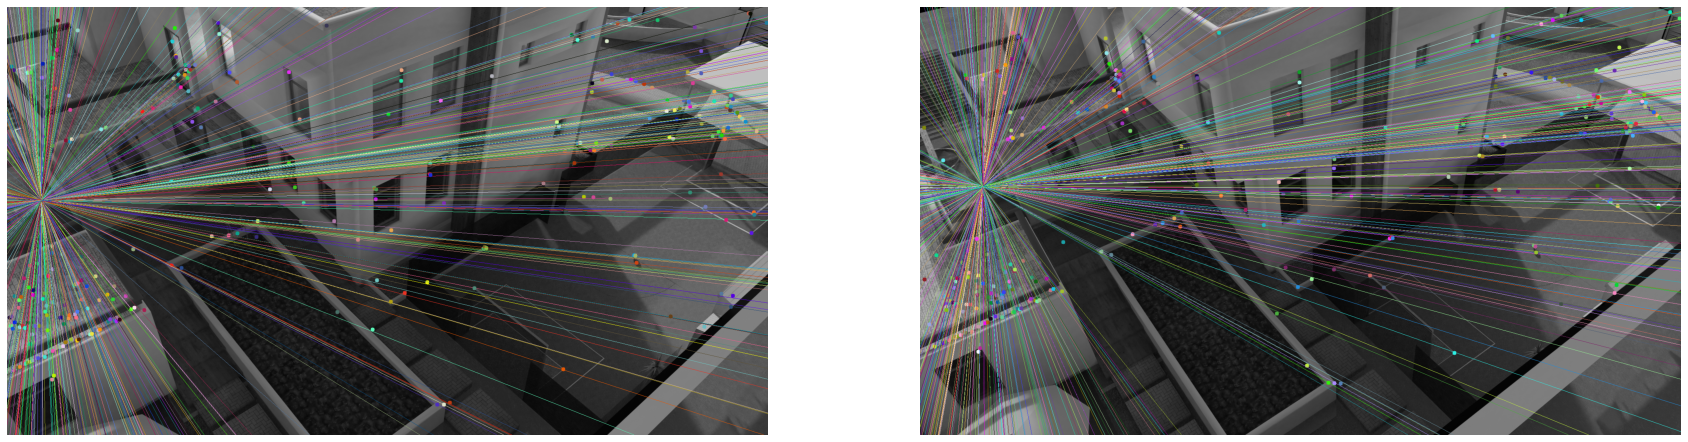

In [168]:
# Find epilines corresponding to points in right image (second image) and draw its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2),2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and draw its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

f, axs = plt.subplots(1,2,figsize=(30,30))
axs[0].imshow(img5, cmap='gray')
axs[0].axis('off')

axs[1].imshow(img3, cmap='gray')
axs[1].axis('off')

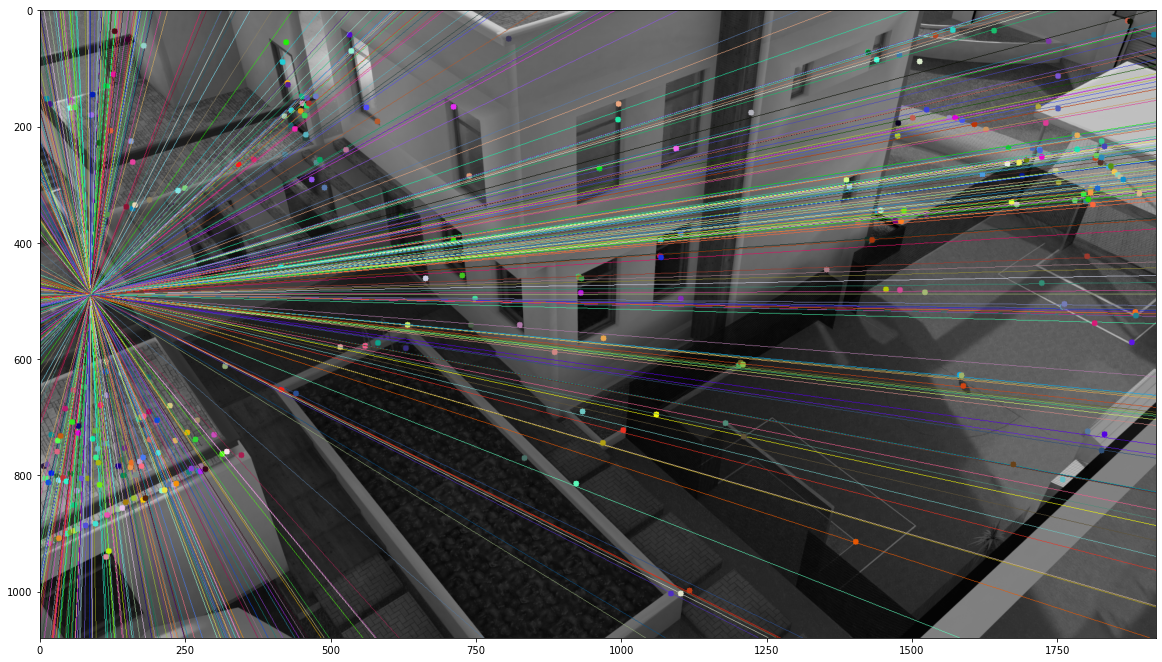

In [169]:
fig, axs=plt.subplots(1,1, figsize=(20,20)) 
axs.imshow(img5, cmap='gray')
plt.show()

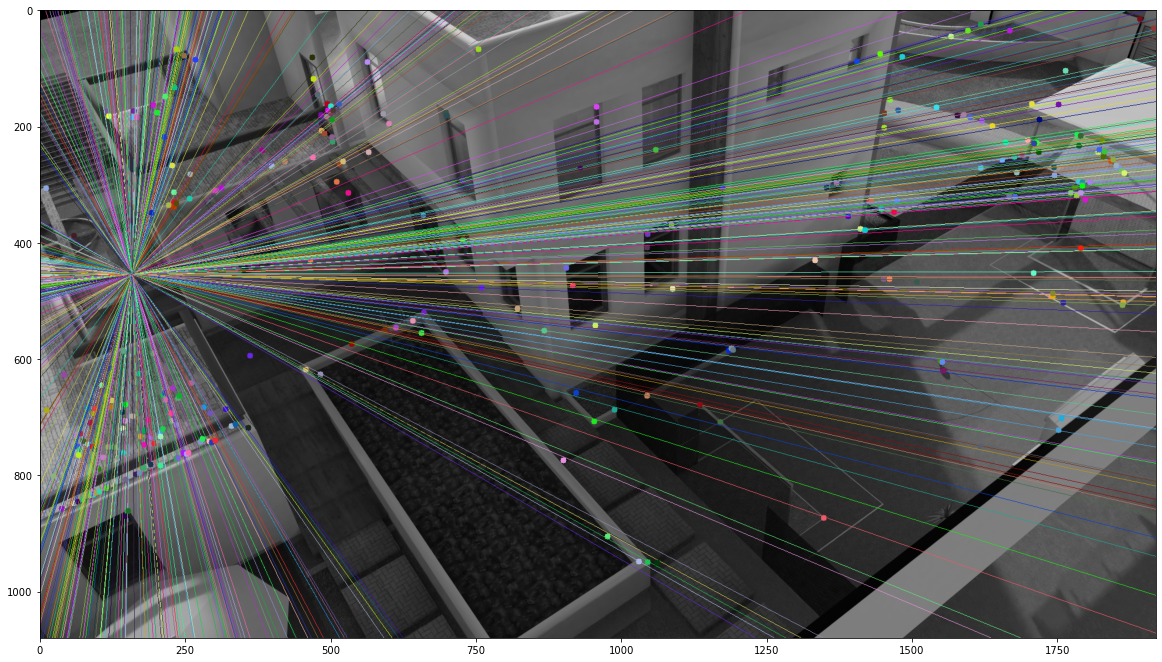

In [157]:
fig, axs=plt.subplots(1,1, figsize=(20,20)) 
axs.imshow(img3, cmap='gray')
plt.show()

(1080, 1920)


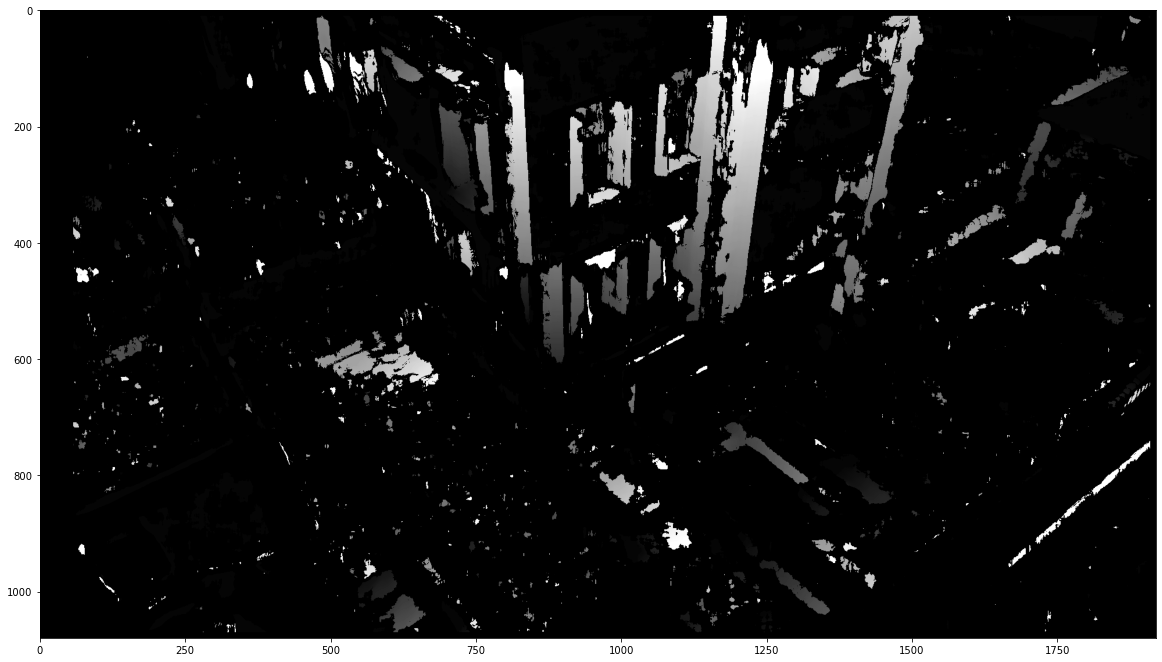

In [208]:
stereo = cv2.StereoBM_create(numDisparities=48, blockSize=21)
disparity = stereo.compute(img1,img2)
print(disparity.shape)
fig, axs=plt.subplots(1,1, figsize=(20,20)) 
axs.imshow(disparity,'gray')
plt.show()

In [207]:
f = 1600
t = np.sqrt(np.sum(T**2))
D = f*t/disparity
# print(D.shape)

M_football_1 = D[340, 1008] * K_inverse @ np.transpose(np.array([1008, 340, 1]))
M_football_2 = D[745, 1661] * K_inverse @ np.transpose(np.array([1661, 745, 1]))
diff = M_football_1 - M_football_2
length = np.sqrt(np.sum(diff**2))
print(length)

M_pool_1 = D[434, 404] * K_inverse @ np.transpose(np.array([404, 434, 1]))
M_pool_2 = D[557, 637] * K_inverse @ np.transpose(np.array([637, 557, 1]))
M_pool_3 = D[76, 1108] * K_inverse @ np.transpose(np.array([1108, 76, 1]))
horiz_diff = M_pool_1 - M_pool_2
verti_diff = M_pool_2 - M_pool_3
horiz_dist = np.sqrt(np.sum(horiz_diff**2))
verti_dist = np.sqrt(np.sum(verti_diff**2))
area = horiz_dist*verti_dist
print(horiz_dist)
print(verti_dist)
print(area)

96.09405872989585
32.949354165664786
84.18927446519459
2773.982221304055


<ipython-input-207-23291d7335e0>:3: RuntimeWarning: divide by zero encountered in true_divide
  D = f*t/disparity
